## Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

# Capstone Project Model Solution

In this notebook, we provide a model solution to an options strategy for the capstone project. You can refer to this if you are stuck in any step while building your solution. The features and parameters added here are not exhaustive or fine-tuned.

The model solution guides you to answer the problem statements posed in the capstone project. The notebook structure is as follows:

1. [Read the Data](#data)
1. [Create Dollar-Volume Bars](#dollarvolumebars)
1. [Backtest the Trading Strategy](#backtest)
1. [Performance Analysis](#performance)

## Import Libraries

In [1]:
# For data manipulation
import pandas as pd
import numpy as np
from scipy.stats import norm

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# For plotting
import matplotlib.pyplot as plt
import mplfinance as mpf

<a id='data'></a>
## Read the Data

In [2]:
# Read the 'tick_data_es500_2013_10_02.bz2' pickle file as 'tick_data' dataframe
tick_data = pd.read_pickle('../data_modules/tick_data_es500_2013_10_02.bz2')

# Print first 5 trades of the 'tick_data' dataframe
tick_data.head()

,bid,ask,trade_price,trade_size
,,,,
2013-10-02 00:00:00.604800,1428.50,1428.75,1428.75,1.0
2013-10-02 00:00:10.972800,1428.50,1428.75,1428.75,25.0
2013-10-02 00:00:19.439999,1428.50,1428.75,1429.00,17.0
2013-10-02 00:00:19.439999,1428.50,1428.75,1429.00,11.0
2013-10-02 00:00:19.526400,1428.75,1429.00,1429.00,28.0


<a id='dollarvolumebars'></a>
## Create Dollar-Volume Bars

In [3]:
# Define dollar-volume threshold
threshold = 100000

### Cumulative Volume

In [4]:
# Calculate dollar volume
tick_data['cumulative_volume'] = tick_data['trade_size']*tick_data['trade_price'].cumsum()

### Initialise Variables

In [5]:
# Initialise variables start_time, end_time, dollar_volume_sum, volume_sum and dollar_volume_bars_list
start_time = None
end_time = None
dollar_volume_sum = 0
volume_sum = 0
dollar_volume_bars_list = []

### Iterate over the Trades

In [6]:
# Create a column 'time' to store the trade entry timestamps
tick_data['time'] = pd.to_datetime(tick_data.index)

In [7]:
# Iterate over rows
for index, row in tick_data.iterrows():
    
    # Check whether the 'dollar_volume_sum' variable is equal to zero to confirm start of new dollar volume bar
    if dollar_volume_sum == 0:

        # If a new dollar volume bar is starting, 'start_time' variable is set to the value in the 'time' column of the current row
        start_time = row['time']

    # Add volume to sum: Add the value in the 'trade_size' column of the current row to the 'volume_sum' variable
    volume_sum += row['trade_size']
    
    # Add dollar volume to sum: Add the value in the 'trade_size' column multiplied by 'trade_price' of the current row to the 'dollar_volume_sum' variable
    dollar_volume_sum += row['trade_size']*row['trade_price']

    # Check whether the 'dollar_volume_sum' variable is greater than or equal to the 'threshold' value
    if dollar_volume_sum >= threshold:

        # If a dollar volume threshold is reached, the 'end_time' variable is set to the value in the 'time' column of the current row
        end_time = row['time']

        # Create a dictionary called 'volume_data' that contains the OHLC data for the current volume bar
        volume_data = {

            # The 'start_time' key is set to the value of 'start_time' variable
            'start_time': start_time,

            # The 'end_time' key is set to the value of 'end_time' variable
            'end_time': end_time,

            # The 'open_price' key is set to the first value in the 'trade_price' column of the row
            # where the 'time' column is equal to the 'start_time' variable
            'open_price': tick_data.loc[tick_data['time'] == start_time, 'trade_price'].iloc[0],

            # The 'high_price' key is set to the maximum value in the 'trade_price' column for rows
            # where the 'time' column is between the 'start_time' and 'end_time' variables
            'high_price': tick_data.loc[start_time:end_time, 'trade_price'].max(),

            # The 'low_price' key is set to the minimum value in the 'trade_price' column for rows
            # where the 'time' column is between the 'start_time' and 'end_time' variables
            'low_price': tick_data.loc[start_time:end_time, 'trade_price'].min(),

            # The 'close_price' key is set to the first value in the 'trade_price' column of the row
            # where the 'time' column is equal to the 'end_time' variable
            'close_price': tick_data.loc[tick_data['time'] == end_time, 'trade_price'].iloc[0],

            # The 'volume' key is set to the value of the 'volume_sum' variable
            'volume': volume_sum
        }

        # Append 'volume_data' dictionary to a list called 'dollar_volume_bars_list'
        # which contains the OHLC data for each dollar volume bar.
        dollar_volume_bars_list.append(volume_data)

        # Resets the 'start_time', 'end_time', 'dollar_volume_sum' and 'volume_sum' variables to None,
        # which prepares the script to start calculating the next dollar volume bar
        start_time = None
        end_time = None
        dollar_volume_sum = 0
        volume_sum = 0

# Total number of dollar volume bars created
print(
    f'The total number of dollar volume bars created from {len(tick_data)} trades: {len(dollar_volume_bars_list)}')

The total number of dollar volume bars created from 77390 trades: 11655


### Create Dollar-Volume Bars Dataframe

In [8]:
# Convert the list of dollar volume bars to dataframe
dollar_volume_bars = pd.DataFrame(dollar_volume_bars_list)

# Define columns of the dollar_volume_bars dataframe
dollar_volume_bars.columns = ['start_time', 'end_time', 'open', 'high', 'low',
                       'close', 'volume']

# Set the start time of the dollar volume bars as the index of the dollar_volume_bars dataframe
dollar_volume_bars.index = dollar_volume_bars.start_time

# Print first 5 volume bars
dollar_volume_bars.head()

,start_time,end_time,open,high,low,close,volume
start_time,,,,,,,
2013-10-02 00:00:00.604800,2013-10-02 00:00:00.604800,2013-10-02 00:00:19.526400,1428.75,1429.0,1428.75,1429.0,82.0
2013-10-02 00:00:19.612800,2013-10-02 00:00:19.612800,2013-10-02 00:03:11.894400,1429.00,1429.0,1428.75,1429.0,71.0
2013-10-02 00:03:13.449600,2013-10-02 00:03:13.449600,2013-10-02 00:04:16.521599,1429.00,1429.0,1428.75,1429.0,107.0
2013-10-02 00:04:16.521599,2013-10-02 00:04:16.521599,2013-10-02 00:05:12.249600,1429.00,1429.0,1428.00,1428.0,72.0
2013-10-02 00:05:12.336000,2013-10-02 00:05:12.336000,2013-10-02 00:08:20.515200,1428.25,1429.0,1428.00,1429.0,78.0


In [9]:
def bvc(data):
    # Calculate the price change
    data['price_change'] = data.close.diff()

    # Calculate volume-weighted price change
    data['vwp_change'] = (data['price_change'] * data['volume']).expanding().sum() / \
        data['volume'].expanding().sum()

    # Calculate rolling standard deviation of volume-weighted price change
    data['vwp_std'] = data['vwp_change'].expanding().std()

    # Calculate the buy volume and store it in the column 'buy_volume' in the dataframe 'data'
    data['buy_volume'] = data['volume'] * \
        ((data['price_change']/data['vwp_std'])
         .apply(lambda x: norm.cdf(x)))

    # Calculate the sell volume and store it in the column 'sell_volume' in the dataframe 'data'
    data['sell_volume'] = data['volume']-data['buy_volume']

    # Calculate the order flow and store it in the column 'order_flow' of the dataframe 'data'
    data['order_flow'] = data['buy_volume']-data['sell_volume']

    # Select columns for the order flow dataframe and drop rows with any missing data
    data = data[['close', 'buy_volume', 'sell_volume', 'order_flow']]
    data = data.dropna()
    
    return data

In [10]:
# Calculate the order flow using the bvc function and store it in `volume_bars`
dollar_volume_bars = bvc(dollar_volume_bars)

# Print the first 20 rows of the dataframe `volume_bars`
dollar_volume_bars.head(20)

,close,buy_volume,sell_volume,order_flow
start_time,,,,
2013-10-02 00:04:16.521599,1428.00,4.990419e-14,72.000000,-72.000000
2013-10-02 00:05:12.336000,1429.00,7.800000e+01,0.000000,78.000000
2013-10-02 00:08:53.606400,1429.00,3.550000e+01,35.500000,0.000000
2013-10-02 00:11:30.076799,1429.00,7.500000e+01,75.000000,0.000000
2013-10-02 00:13:21.878400,1429.00,7.150000e+01,71.500000,0.000000
2013-10-02 00:16:15.369600,1428.25,1.285573e-19,71.000000,-71.000000
2013-10-02 00:22:43.910400,1428.00,3.309576e-02,69.966904,-69.933808
2013-10-02 00:22:48.748799,1428.00,5.650000e+01,56.500000,0.000000
2013-10-02 00:23:22.012800,1428.00,3.600000e+01,36.000000,0.000000


<a id='backtest'></a>
## Backtest the Trading Strategy

In [11]:
# Calculate the cumulative order flow and store it in the column 'cumulative_order_flow'
dollar_volume_bars['cumulative_order_flow'] = dollar_volume_bars['order_flow'].cumsum()

# Initialise the variable pos to 0, which will be used to keep track of the current position
pos = 0

# Create an empty list called entry_time that will be used to store the time at which trades are entered
entry_time = []

# Create an empty list called exit_time that will be used to store the time at which trades are exited
exit_time = []

# Initialise an empty Pandas DataFrame called 'trades' to save trade details
trades = pd.DataFrame(
    columns=['entry_time', 'exit_time', 'direction', 'entry_price', 'exit_price'])

# Create a list of all indices in the dataframe and store it in `indices_total`
indices = dollar_volume_bars.index.tolist()

# Remove duplicate entries from the dollar_volume_bars dataframe, keeping only the first occurrence of each duplicated index value.
dollar_volume_bars = dollar_volume_bars[~dollar_volume_bars.index.duplicated(keep='first')]

# Define the lookback for the dollar volume bars
lookback = 20

# Looping over the indices filtered
for i in range(lookback, len(indices)):

    # Set the current index to the i-1 th index of the 'indices' list
    current_index = indices[i-1]

    # Set the start index to lookback bars before the current index
    start_index = indices[i-lookback]

    # Find all indices within the previous lookback bars from the index of the current row
    indices_within_lookback_bars = [
        j for j in indices if j >= start_index and j < current_index]

    # Calculate the net order flow by taking the difference between the cumulative order flow at the beginning and end the lookback period
    order_flow = (dollar_volume_bars.loc[indices_within_lookback_bars].cumulative_order_flow.iloc[-1]) - (
        dollar_volume_bars.loc[indices_within_lookback_bars].cumulative_order_flow.iloc[0])

    # Calculate various order flow thresholds based on percentiles
    # long_entry_threshold: 75th percentile of order flow in the lookback period as the threshold for the long entry
    long_entry_threshold = np.percentile(
        dollar_volume_bars.loc[start_index:current_index].order_flow, 75)

    # long_exit_threshold: 50th percentile of order flow in the lookback period as the stop-loss threshold for the long exit
    long_exit_threshold = np.percentile(
        dollar_volume_bars.loc[start_index:current_index].order_flow, 50)

    # long_takeprofit_threshold: 90th percentile of order flow in the lookback period as the take-profit threshold for the long exit
    long_takeprofit_threshold = np.percentile(
        dollar_volume_bars.loc[start_index:current_index].order_flow, 90)

    # short_entry_threshold: 25th percentile of order flow in the lookback period as the threshold for the short entry
    short_entry_threshold = np.percentile(
        dollar_volume_bars.loc[start_index:current_index].order_flow, 25)

    # short_exit_threshold: 50th percentile of order flow in the lookback period as the stop-loss threshold for the short exit
    short_exit_threshold = np.percentile(
        dollar_volume_bars.loc[start_index:current_index].order_flow, 50)

    # short_takeprofit_threshold: 10th percentile of order flow in the lookback period as the take-profit threshold for the short exit
    short_takeprofit_threshold = np.percentile(
        dollar_volume_bars.loc[start_index:current_index].order_flow, 10)


# Check if there are any open positions
    if (pos == 0):

        # Check if the net order flow is strong and positive
        if (order_flow > long_entry_threshold and order_flow < long_takeprofit_threshold ):

            # Enter long position
            print('Entering long position')
            print('Long entering time', indices[i])

            # Note the long entry time
            entry_time = indices[i]

            # Note the entry price
            entry_price = dollar_volume_bars.loc[indices[i]].close

            # Set pos to 1 since long trade was entered
            pos = 1
            print('pos is ', pos)

        # Check if the net order flow is weak and negative
        elif (order_flow < short_entry_threshold and order_flow > short_takeprofit_threshold ):

            # Enter short position
            print('entering short')
            print('short entering time', indices[i])

            # Note the short entry time
            entry_time = indices[i]

            # Note the entry price
            entry_price = dollar_volume_bars.loc[indices[i]].close

            # Set pos to -1 since short trade was entered
            pos = -1
            print('pos is ', pos)

    # Check if there is an open long position
    elif (pos > 0):

        # Check if the net order flow has fallen below the exit threshold or risen above the take profit threshold
        if (order_flow <= long_exit_threshold or order_flow >= long_takeprofit_threshold):

            # Exit long position
            print('exiting long')
            print('long exiting time', indices[i])

            # Adding trade to trades dataframe since the trade is getting closed
            # Columns: 'entry_time', 'exit_time', 'direction', 'entry_price', 'exit_price'
            trades.loc[entry_time] = [entry_time, indices[i],
                                      1, entry_price, dollar_volume_bars.loc[indices[i]].close]
            print([entry_time, indices[i],
                   1, entry_price, dollar_volume_bars.loc[indices[i]].close])
            
            # Set pos to 0 since the long trade was exited
            pos = 0
            print('pos is ', pos)
            print('**************** Trade Ended ****************')

    # Check if there is an open short position
    elif (pos < 0):

        # Check if the net order flow has risen above the exit threshold or fallen below the take profit threshold
        if (order_flow >= short_exit_threshold or order_flow <= short_takeprofit_threshold):

            # Exit short position
            print('exiting short')
            print('short exiting time', indices[i])

            # Adding trade to trades dataframe since the trade is getting closed
            # Columns: 'entry_time', 'exit_time', 'direction', 'entry_price', 'exit_price'
            trades.loc[entry_time] = [entry_time, indices[i],
                                      -1, entry_price, dollar_volume_bars.loc[indices[i]].close]
            print([entry_time, indices[i],
                   1, entry_price, dollar_volume_bars.loc[indices[i]].close])
            
            # Set pos to 0 since the short trade was exited
            pos = 0
            print('pos is ', pos)
            print('**************** Trade Ended ****************')

entering short
short entering time 2013-10-02 00:55:18.537600
pos is  -1
exiting short
short exiting time 2013-10-02 00:55:52.060799
[Timestamp('2013-10-02 00:55:18.537600'), Timestamp('2013-10-02 00:55:52.060799'), 1, 1428.0, 1428.0]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 01:01:19.603200
pos is  -1
exiting short
short exiting time 2013-10-02 01:15:10.080000
[Timestamp('2013-10-02 01:01:19.603200'), Timestamp('2013-10-02 01:15:10.080000'), 1, 1428.0, 1429.0]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 01:55:36.969600
pos is  1
exiting long
long exiting time 2013-10-02 01:58:10.156800
[Timestamp('2013-10-02 01:55:36.969600'), Timestamp('2013-10-02 01:58:10.156800'), 1, 1430.0, 1430.0]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 01:59:45.715200
pos is  1
exiting long
long exiting time 2013-10-02 02

Entering long position
Long entering time 2013-10-02 04:42:24.681600
pos is  1
exiting long
long exiting time 2013-10-02 04:42:24.768000
[Timestamp('2013-10-02 04:42:24.681600'), Timestamp('2013-10-02 04:42:24.768000'), 1, 1440.0, 1440.0]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 04:50:51.590400
pos is  -1
exiting short
short exiting time 2013-10-02 04:50:58.156800
[Timestamp('2013-10-02 04:50:51.590400'), Timestamp('2013-10-02 04:50:58.156800'), 1, 1441.0, 1441.0]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 04:51:59.328000
pos is  -1
exiting short
short exiting time 2013-10-02 04:52:06.499200
[Timestamp('2013-10-02 04:51:59.328000'), Timestamp('2013-10-02 04:52:06.499200'), 1, 1440.0, 1440.0]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 04:55:38.438400
pos is  1
exiting long
long exiting time 2013-10-02 04

exiting long
long exiting time 2013-10-02 07:08:34.627200
[Timestamp('2013-10-02 07:08:13.459199'), Timestamp('2013-10-02 07:08:34.627200'), 1, 1441.0, 1440.5]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 07:08:52.252800
pos is  -1
exiting short
short exiting time 2013-10-02 07:09:41.155200
[Timestamp('2013-10-02 07:08:52.252800'), Timestamp('2013-10-02 07:09:41.155200'), 1, 1440.0, 1440.0]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 07:14:03.897599
pos is  -1
exiting short
short exiting time 2013-10-02 07:14:21.523200
[Timestamp('2013-10-02 07:14:03.897599'), Timestamp('2013-10-02 07:14:21.523200'), 1, 1440.0, 1440.0]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 07:16:55.574400
pos is  -1
exiting short
short exiting time 2013-10-02 07:17:35.318400
[Timestamp('2013-10-02 07:16:55.574400'), Timestamp('2013-10-02 07:17

Entering long position
Long entering time 2013-10-02 09:03:52.588800
pos is  1
exiting long
long exiting time 2013-10-02 09:03:55.526400
[Timestamp('2013-10-02 09:03:52.588800'), Timestamp('2013-10-02 09:03:55.526400'), 1, 1441.0, 1441.0]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 09:05:52.771200
pos is  1
exiting long
long exiting time 2013-10-02 09:06:01.324800
[Timestamp('2013-10-02 09:05:52.771200'), Timestamp('2013-10-02 09:06:01.324800'), 1, 1441.0, 1441.0]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 09:06:57.052800
pos is  1
exiting long
long exiting time 2013-10-02 09:07:02.323200
[Timestamp('2013-10-02 09:06:57.052800'), Timestamp('2013-10-02 09:07:02.323200'), 1, 1441.0, 1441.0]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 09:07:04.224000
pos is  1
exiting long
long exiting time 2013-

entering short
short entering time 2013-10-02 09:36:36.979200
pos is  -1
exiting short
short exiting time 2013-10-02 09:36:39.225600
[Timestamp('2013-10-02 09:36:36.979200'), Timestamp('2013-10-02 09:36:39.225600'), 1, 1443.0, 1442.5]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 09:36:58.924800
pos is  -1
exiting short
short exiting time 2013-10-02 09:36:59.011200
[Timestamp('2013-10-02 09:36:58.924800'), Timestamp('2013-10-02 09:36:59.011200'), 1, 1443.0, 1442.0]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 09:37:39.100800
pos is  1
exiting long
long exiting time 2013-10-02 09:37:46.963200
[Timestamp('2013-10-02 09:37:39.100800'), Timestamp('2013-10-02 09:37:46.963200'), 1, 1443.0, 1443.0]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 09:37:47.049600
pos is  1
exiting long
long exiting time 2013-10-02 09

entering short
short entering time 2013-10-02 09:50:17.606400
pos is  -1
exiting short
short exiting time 2013-10-02 09:50:18.384000
[Timestamp('2013-10-02 09:50:17.606400'), Timestamp('2013-10-02 09:50:18.384000'), 1, 1442.0, 1442.0]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 09:52:50.188800
pos is  1
exiting long
long exiting time 2013-10-02 09:52:50.620800
[Timestamp('2013-10-02 09:52:50.188800'), Timestamp('2013-10-02 09:52:50.620800'), 1, 1442.0, 1442.0]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 09:52:51.830400
pos is  1
exiting long
long exiting time 2013-10-02 09:52:53.385600
[Timestamp('2013-10-02 09:52:51.830400'), Timestamp('2013-10-02 09:52:53.385600'), 1, 1442.0, 1442.0]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 09:53:16.713600
pos is  -1
exiting short
short exiting time 2013-10-02 09

Entering long position
Long entering time 2013-10-02 10:01:57.100800
pos is  1
exiting long
long exiting time 2013-10-02 10:01:57.187200
[Timestamp('2013-10-02 10:01:57.100800'), Timestamp('2013-10-02 10:01:57.187200'), 1, 1449.0, 1449.0]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 10:02:06.345600
pos is  1
exiting long
long exiting time 2013-10-02 10:02:11.356800
[Timestamp('2013-10-02 10:02:06.345600'), Timestamp('2013-10-02 10:02:11.356800'), 1, 1449.0, 1449.0]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 10:02:11.443200
pos is  1
exiting long
long exiting time 2013-10-02 10:02:11.616000
[Timestamp('2013-10-02 10:02:11.443200'), Timestamp('2013-10-02 10:02:11.616000'), 1, 1449.0, 1449.0]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 10:02:24.662400
pos is  -1
exiting short
short exiting time 2013-10-0

entering short
short entering time 2013-10-02 10:05:56.601600
pos is  -1
exiting short
short exiting time 2013-10-02 10:05:58.761600
[Timestamp('2013-10-02 10:05:56.601600'), Timestamp('2013-10-02 10:05:58.761600'), 1, 1450.0, 1450.0]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 10:06:02.736000
pos is  -1
exiting short
short exiting time 2013-10-02 10:06:02.908800
[Timestamp('2013-10-02 10:06:02.736000'), Timestamp('2013-10-02 10:06:02.908800'), 1, 1450.0, 1450.0]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 10:06:04.723200
pos is  -1
exiting short
short exiting time 2013-10-02 10:06:06.278400
[Timestamp('2013-10-02 10:06:04.723200'), Timestamp('2013-10-02 10:06:06.278400'), 1, 1450.0, 1449.5]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 10:06:07.833600
pos is  1
exiting long
long exiting time 2013-10-02 10:06:

Entering long position
Long entering time 2013-10-02 10:11:12.912000
pos is  1
exiting long
long exiting time 2013-10-02 10:11:14.380800
[Timestamp('2013-10-02 10:11:12.912000'), Timestamp('2013-10-02 10:11:14.380800'), 1, 1450.0, 1450.0]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 10:11:44.275200
pos is  -1
exiting short
short exiting time 2013-10-02 10:11:45.916800
[Timestamp('2013-10-02 10:11:44.275200'), Timestamp('2013-10-02 10:11:45.916800'), 1, 1450.0, 1451.0]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 10:11:45.916800
pos is  1
exiting long
long exiting time 2013-10-02 10:11:45.916800
[Timestamp('2013-10-02 10:11:45.916800'), Timestamp('2013-10-02 10:11:45.916800'), 1, 1451.0, 1451.0]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 10:12:12.960000
pos is  1
exiting long
long exiting time 2013-10-0

entering short
short entering time 2013-10-02 10:30:02.246400
pos is  -1
exiting short
short exiting time 2013-10-02 10:30:02.332800
[Timestamp('2013-10-02 10:30:02.246400'), Timestamp('2013-10-02 10:30:02.332800'), 1, 1449.0, 1449.0]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 10:30:09.676800
pos is  1
exiting long
long exiting time 2013-10-02 10:30:09.763200
[Timestamp('2013-10-02 10:30:09.676800'), Timestamp('2013-10-02 10:30:09.763200'), 1, 1449.0, 1448.75]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 10:30:24.883200
pos is  -1
exiting short
short exiting time 2013-10-02 10:30:25.142400
[Timestamp('2013-10-02 10:30:24.883200'), Timestamp('2013-10-02 10:30:25.142400'), 1, 1449.0, 1449.0]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 10:34:35.097600
pos is  -1
exiting short
short exiting time 2013-10-02 10:34

entering short
short entering time 2013-10-02 11:01:10.214400
pos is  -1
exiting short
short exiting time 2013-10-02 11:01:10.560000
[Timestamp('2013-10-02 11:01:10.214400'), Timestamp('2013-10-02 11:01:10.560000'), 1, 1449.0, 1449.0]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 11:01:52.550400
pos is  -1
exiting short
short exiting time 2013-10-02 11:02:06.547200
[Timestamp('2013-10-02 11:01:52.550400'), Timestamp('2013-10-02 11:02:06.547200'), 1, 1448.5, 1449.0]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 11:03:22.147200
pos is  1
exiting long
long exiting time 2013-10-02 11:03:22.233600
[Timestamp('2013-10-02 11:03:22.147200'), Timestamp('2013-10-02 11:03:22.233600'), 1, 1449.0, 1449.0]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 11:03:29.923200
pos is  1
exiting long
long exiting time 2013-10-02 11

Entering long position
Long entering time 2013-10-02 11:51:49.507200
pos is  1
exiting long
long exiting time 2013-10-02 11:51:49.507200
[Timestamp('2013-10-02 11:51:49.507200'), Timestamp('2013-10-02 11:51:49.507200'), 1, 1448.0, 1448.0]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 11:54:51.379199
pos is  1
exiting long
long exiting time 2013-10-02 11:55:00.624000
[Timestamp('2013-10-02 11:54:51.379199'), Timestamp('2013-10-02 11:55:00.624000'), 1, 1447.0, 1447.0]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 11:55:27.235199
pos is  -1
exiting short
short exiting time 2013-10-02 11:55:27.235199
[Timestamp('2013-10-02 11:55:27.235199'), Timestamp('2013-10-02 11:55:27.235199'), 1, 1447.0, 1447.0]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 11:55:36.998400
pos is  -1
exiting short
short exiting time 2013-10-02 11

Entering long position
Long entering time 2013-10-02 12:43:17.875199
pos is  1
exiting long
long exiting time 2013-10-02 12:43:20.640000
[Timestamp('2013-10-02 12:43:17.875199'), Timestamp('2013-10-02 12:43:20.640000'), 1, 1447.25, 1447.0]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 12:43:28.156800
pos is  -1
exiting short
short exiting time 2013-10-02 12:43:28.156800
[Timestamp('2013-10-02 12:43:28.156800'), Timestamp('2013-10-02 12:43:28.156800'), 1, 1447.0, 1447.0]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 12:43:49.065600
pos is  1
exiting long
long exiting time 2013-10-02 12:44:14.380800
[Timestamp('2013-10-02 12:43:49.065600'), Timestamp('2013-10-02 12:44:14.380800'), 1, 1447.0, 1447.0]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 12:46:39.532800
pos is  -1
exiting short
short exiting time 2013-10-02 1

entering short
short entering time 2013-10-02 13:09:54.547200
pos is  -1
exiting short
short exiting time 2013-10-02 13:09:54.633599
[Timestamp('2013-10-02 13:09:54.547200'), Timestamp('2013-10-02 13:09:54.633599'), 1, 1442.0, 1442.0]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 13:09:55.065600
pos is  1
exiting long
long exiting time 2013-10-02 13:09:55.843200
[Timestamp('2013-10-02 13:09:55.065600'), Timestamp('2013-10-02 13:09:55.843200'), 1, 1442.0, 1441.0]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 13:09:55.843200
pos is  -1
exiting short
short exiting time 2013-10-02 13:09:55.843200
[Timestamp('2013-10-02 13:09:55.843200'), Timestamp('2013-10-02 13:09:55.843200'), 1, 1441.0, 1441.0]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 13:09:57.312000
pos is  -1
exiting short
short exiting time 2013-10-02 13:09:

entering short
short entering time 2013-10-02 13:16:41.836800
pos is  -1
exiting short
short exiting time 2013-10-02 13:16:43.651200
[Timestamp('2013-10-02 13:16:41.836800'), Timestamp('2013-10-02 13:16:43.651200'), 1, 1439.0, 1439.25]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 13:16:46.934400
pos is  1
exiting long
long exiting time 2013-10-02 13:16:57.907200
[Timestamp('2013-10-02 13:16:46.934400'), Timestamp('2013-10-02 13:16:57.907200'), 1, 1439.0, 1440.0]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 13:17:08.015999
pos is  1
exiting long
long exiting time 2013-10-02 13:17:16.051200
[Timestamp('2013-10-02 13:17:08.015999'), Timestamp('2013-10-02 13:17:16.051200'), 1, 1439.5, 1440.0]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 13:17:46.982399
pos is  1
exiting long
long exiting time 2013-10-

Entering long position
Long entering time 2013-10-02 13:50:26.534400
pos is  1
exiting long
long exiting time 2013-10-02 13:50:29.471999
[Timestamp('2013-10-02 13:50:26.534400'), Timestamp('2013-10-02 13:50:29.471999'), 1, 1441.5, 1442.0]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 13:52:25.766400
pos is  1
exiting long
long exiting time 2013-10-02 13:52:25.852799
[Timestamp('2013-10-02 13:52:25.766400'), Timestamp('2013-10-02 13:52:25.852799'), 1, 1442.0, 1441.0]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 13:52:29.740800
pos is  1
exiting long
long exiting time 2013-10-02 13:52:37.776000
[Timestamp('2013-10-02 13:52:29.740800'), Timestamp('2013-10-02 13:52:37.776000'), 1, 1442.0, 1442.0]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 13:53:28.060800
pos is  1
exiting long
long exiting time 2013-

Entering long position
Long entering time 2013-10-02 14:46:03.648000
pos is  1
exiting long
long exiting time 2013-10-02 14:46:03.734400
[Timestamp('2013-10-02 14:46:03.648000'), Timestamp('2013-10-02 14:46:03.734400'), 1, 1443.0, 1443.0]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 14:51:40.262400
pos is  -1
exiting short
short exiting time 2013-10-02 14:51:43.200000
[Timestamp('2013-10-02 14:51:40.262400'), Timestamp('2013-10-02 14:51:43.200000'), 1, 1443.0, 1443.0]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 14:52:43.161600
pos is  1
exiting long
long exiting time 2013-10-02 14:53:05.020800
[Timestamp('2013-10-02 14:52:43.161600'), Timestamp('2013-10-02 14:53:05.020800'), 1, 1443.0, 1443.0]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 14:53:06.057600
pos is  1
exiting long
long exiting time 2013-10-0

Entering long position
Long entering time 2013-10-02 15:20:20.313600
pos is  1
exiting long
long exiting time 2013-10-02 15:20:20.400000
[Timestamp('2013-10-02 15:20:20.313600'), Timestamp('2013-10-02 15:20:20.400000'), 1, 1437.0, 1436.0]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 15:20:26.534400
pos is  -1
exiting short
short exiting time 2013-10-02 15:20:27.657600
[Timestamp('2013-10-02 15:20:26.534400'), Timestamp('2013-10-02 15:20:27.657600'), 1, 1436.0, 1436.25]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 15:20:44.764800
pos is  -1
exiting short
short exiting time 2013-10-02 15:20:44.764800
[Timestamp('2013-10-02 15:20:44.764800'), Timestamp('2013-10-02 15:20:44.764800'), 1, 1436.0, 1436.0]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 15:20:45.974400
pos is  -1
exiting short
short exiting time 2013-10-02 15:20

Entering long position
Long entering time 2013-10-02 15:35:07.382400
pos is  1
exiting long
long exiting time 2013-10-02 15:35:08.073599
[Timestamp('2013-10-02 15:35:07.382400'), Timestamp('2013-10-02 15:35:08.073599'), 1, 1437.0, 1437.0]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 15:36:21.340800
pos is  1
exiting long
long exiting time 2013-10-02 15:36:22.204800
[Timestamp('2013-10-02 15:36:21.340800'), Timestamp('2013-10-02 15:36:22.204800'), 1, 1437.0, 1437.25]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 15:36:22.291200
pos is  1
exiting long
long exiting time 2013-10-02 15:36:23.846399
[Timestamp('2013-10-02 15:36:22.291200'), Timestamp('2013-10-02 15:36:23.846399'), 1, 1437.0, 1437.0]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 15:36:33.263999
pos is  -1
exiting short
short exiting time 2013-10-

entering short
short entering time 2013-10-02 15:50:15.360000
pos is  -1
exiting short
short exiting time 2013-10-02 15:50:18.124800
[Timestamp('2013-10-02 15:50:15.360000'), Timestamp('2013-10-02 15:50:18.124800'), 1, 1438.0, 1437.0]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 15:51:13.852800
pos is  -1
exiting short
short exiting time 2013-10-02 15:51:20.419200
[Timestamp('2013-10-02 15:51:13.852800'), Timestamp('2013-10-02 15:51:20.419200'), 1, 1437.0, 1437.0]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 15:51:44.870400
pos is  -1
exiting short
short exiting time 2013-10-02 15:51:47.635200
[Timestamp('2013-10-02 15:51:44.870400'), Timestamp('2013-10-02 15:51:47.635200'), 1, 1437.0, 1437.0]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 15:51:50.400000
pos is  -1
exiting short
short exiting time 2013-10-02 15:51:52.7

Entering long position
Long entering time 2013-10-02 16:14:32.582400
pos is  1
exiting long
long exiting time 2013-10-02 16:14:32.928000
[Timestamp('2013-10-02 16:14:32.582400'), Timestamp('2013-10-02 16:14:32.928000'), 1, 1437.25, 1437.0]
pos is  0
**************** Trade Ended ****************
Entering long position
Long entering time 2013-10-02 16:14:33.273600
pos is  1
exiting long
long exiting time 2013-10-02 16:14:36.988800
[Timestamp('2013-10-02 16:14:33.273600'), Timestamp('2013-10-02 16:14:36.988800'), 1, 1437.0, 1437.0]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 16:14:51.244800
pos is  -1
exiting short
short exiting time 2013-10-02 16:14:53.059200
[Timestamp('2013-10-02 16:14:51.244800'), Timestamp('2013-10-02 16:14:53.059200'), 1, 1437.0, 1437.0]
pos is  0
**************** Trade Ended ****************
entering short
short entering time 2013-10-02 16:14:55.046400
pos is  -1
exiting short
short exiting time 2013-10-02 1

<a id='performance'></a>
## Performance Analysis

In [12]:
# Profit and loss of trades
trades['pnl'] = trades.direction*(trades.exit_price - trades.entry_price)

# Returns of each trade
trades['returns'] = 100 * trades['pnl']/trades['entry_price']

# Print last 5 trades
trades.tail()

,entry_time,exit_time,direction,entry_price,exit_price,pnl,returns
2013-10-02 23:14:14.294400,2013-10-02 23:14:14.294400,2013-10-02 23:16:00.825600,-1,1439.0,1438.50,0.50,0.034746
2013-10-02 23:20:24.345600,2013-10-02 23:20:24.345600,2013-10-02 23:24:57.888000,1,1438.5,1438.50,0.00,0.000000
2013-10-02 23:30:38.908799,2013-10-02 23:30:38.908799,2013-10-02 23:35:28.435200,-1,1439.0,1439.00,-0.00,-0.000000
2013-10-02 23:39:43.315200,2013-10-02 23:39:43.315200,2013-10-02 23:44:03.379200,-1,1439.0,1438.25,0.75,0.052120
2013-10-02 23:53:46.233599,2013-10-02 23:53:46.233599,2013-10-02 23:54:03.859200,-1,1438.0,1438.00,-0.00,-0.000000


In [13]:
# Calculate the cumulative return
cumulative_return = (1 + trades['returns']).cumprod() - 1

# Print cumulative returns of the strategy
print(
    f'Cumulative returns of the strategy: {np.round(cumulative_return[-1],4)} %')

Cumulative returns of the strategy: -0.3155 %


## Plot the Performance

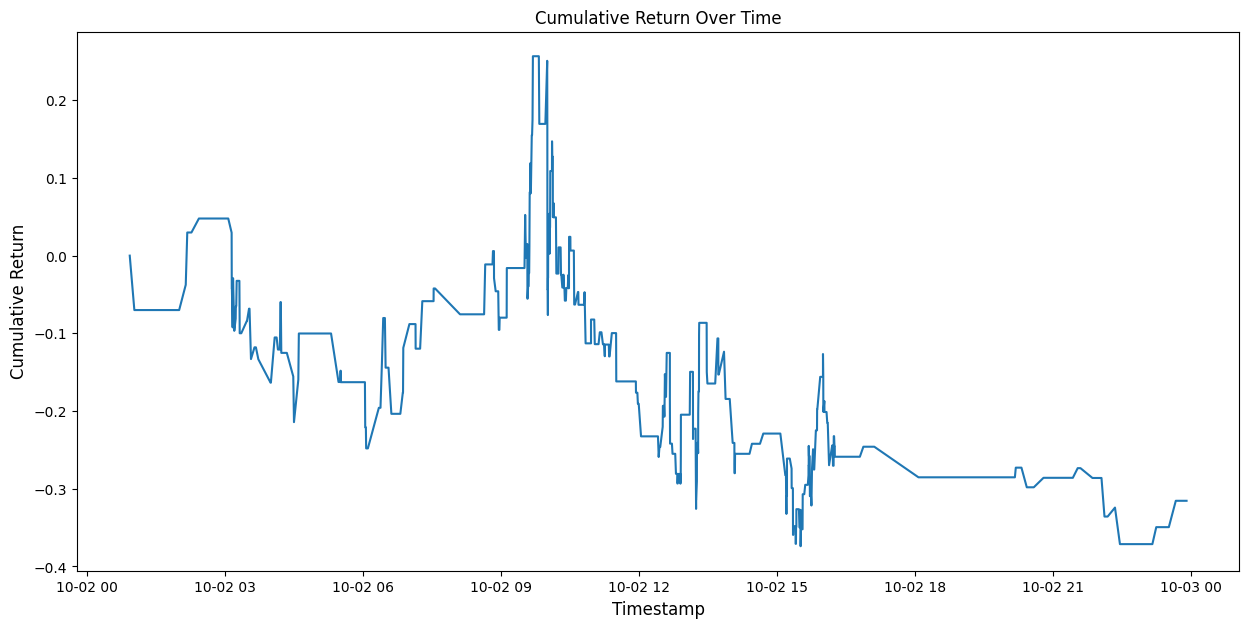

In [14]:
# Create a figure and subplot with a specific size
fig, ax = plt.subplots(figsize=(15, 7))

# Plot the cumulative return
ax.plot(cumulative_return.index, cumulative_return.values)

# Set the x-axis label and font size
ax.set_xlabel('Timestamp', fontsize=12)

# Set the y-axis label
ax.set_ylabel('Cumulative Return', fontsize=12)

# Set the title of the plot
ax.set_title('Cumulative Return Over Time')

# Display the plot
plt.show()